# Met Office Climate Data Hackathon

## Using iris with UK Climate Projections data

This notebook shows you how to work with the UK Climate Projections netCDF files available on the CEDA Archive 
using the xarray Python library. It demonstrates:
 * how to read in a dataset
 * perform a few statistical tasks
  * calculate decadal means
  * calculate a simple spatial-averaging  
  * calculate monthly anomalies
 * how to create a simple and more advanced plots

This module requires the following:

*  Python packages in your environment 
 * iris
 * numpy
 * cartopy
 * iris
 
* UKCP data files
 * monthly mean surface air temperature (available from CEDA Archive [here](http://dap.ceda.ac.uk/badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tas/mon/latest/tas_rcp85_land-rcm_uk_12km_01_mon_198012-208011.nc))
 * land mask (available on this wiki [here](https://github.com/COP26-Hackathon/Met-Office-Climate-Data-Challenge-March_2021/blob/main/Wiki/assets/lsm_land-rcm_uk_12km.nc))
 * daily maximum surface air temperatures (available from CEDA Archive [here](http://data.ceda.ac.uk/badc/ukcp18/data/land-gcm/uk/60km/rcp85/04/tasmax/day/latest))

# Preparatory actions

Load packages

In [1]:
import iris
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation
from pathlib import Path
%matplotlib inline

Assign file locations

In [36]:
UKCP_FILE = 'Insert directory for downloaded file here/tas_rcp85_land-rcm_uk_12km_01_mon_198012-208011.nc'
UKCP_FILE_LAND_MASK = 'Insert directory for downloaded file here/lsm_land-rcm_uk_12km.nc'
UKCP_FILE_DIRECTORY_TASMAX = 'Insert directory for downloaded file here'

## Load a cube and check the metadata

Load one or more netcdf data files into a dataset

In [3]:
cube = iris.load_cube(UKCP_FILE, iris.Constraint(ensemble_member=1))

Show metadata from the netcdf file

In [4]:
cube

Air Temperature (degC),time,projection_y_coordinate,projection_x_coordinate
Shape,1200,112,82
Dimension coordinates,,,
time,x,-,-
projection_y_coordinate,-,x,-
projection_x_coordinate,-,-,x
Auxiliary coordinates,,,
month_number,x,-,-
year,x,-,-
yyyymm,x,-,-
grid_latitude,-,x,x


## Resample data to decadal means

Set up start and years

In [5]:
first_year = cube.coord('year').points[0]
final_year = cube.coord('year').points[-1]

Calculate decadal means for each month

In [6]:
iris.coord_categorisation.add_season_year(cube, 'time')
cube_decade = iris.cube.CubeList()
for year in np.arange(first_year, final_year, 10):
    cube_10years = cube.extract(iris.Constraint(season_year=np.arange(year, year + 10)))
    
    # tidy non-essential metadata
    cube_10years.remove_coord('month_number')
    cube_10years.remove_coord('year')
    cube_10years.remove_coord('season_year')
    cube_mean = cube_10years.collapsed(['time'], iris.analysis.MEAN)
    
    cube_decade.append(cube_mean)
    
cube_decade = cube_decade.merge_cube()

Tidy non-essential metadata

In [7]:
cube_decade.remove_coord('grid_latitude')
cube_decade.remove_coord('grid_longitude')

Produce a mean across spatial variables. Note, this doesn't have area weighting!

In [8]:
cube_decade_spatial_mean = cube_decade.collapsed(['projection_x_coordinate', 
                                                  'projection_y_coordinate'], iris.analysis.MEAN)

Create plot using iris

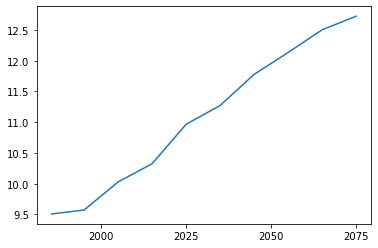

In [9]:
iplt.plot(cube_decade_spatial_mean)

## Plot a smoothed time series of monthly means

Create a running mean, plot then overplot higher frequency values from deca

In [10]:
cube_smoothed = cube.rolling_window('time', iris.analysis.MEAN, 12)

/opt/scitools/environments/experimental/current/lib/python3.6/site-packages/iris/cube.py:4309: UserWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  "the rolling window operation." % coord_.name()


Tidy non-essential metadata and calculate domain-wide mean for smoothed values

In [11]:
if cube_smoothed.coords('grid_latitude'):
    cube_smoothed.remove_coord('grid_latitude')
if cube_smoothed.coords('grid_longitude'):
    cube_smoothed.remove_coord('grid_longitude')
cube_smoothed_spatial_mean = cube_smoothed.collapsed(['projection_x_coordinate', 
                                                          'projection_y_coordinate'], 
                                                         iris.analysis.MEAN)

Tidy non-essential metadata and calculate domain-wide mean

In [12]:
if cube.coords('grid_latitude'):
    cube.remove_coord('grid_latitude')
if cube.coords('grid_longitude'):
    cube.remove_coord('grid_longitude')
cube_spatial_mean = cube.collapsed(['projection_x_coordinate', 
                                    'projection_y_coordinate'], 
                                   iris.analysis.MEAN)

Create plot with iris comparing smoothed and monthly means

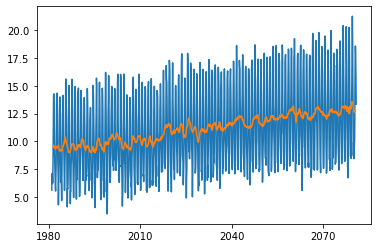

In [13]:
iplt.plot(cube_spatial_mean)
iplt.plot(cube_smoothed_spatial_mean)
plt.show()

## Plot a map
Create a simple plot of the first time step in the data

/opt/scitools/environments/experimental/current/lib/python3.6/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


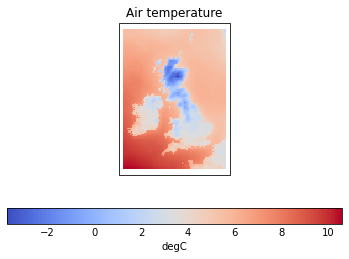

In [14]:
cube_plot = cube[0, :, :]
qplt.pcolormesh(cube_plot, cmap='coolwarm')

Apply a land/sea mask then plot

/opt/scitools/environments/experimental/current/lib/python3.6/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


Text(0.5, 1.0, 'first dataarray with land/sea mask applied')

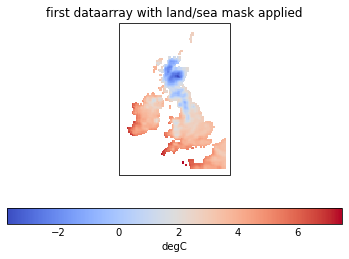

In [15]:
mask = iris.load_cube(UKCP_FILE_LAND_MASK)
cube_plot_masked = cube_plot.copy()
cube_plot_masked.data.mask = mask.data.mask
qplt.pcolormesh(cube_plot_masked, cmap='coolwarm')
plt.title('first dataarray with land/sea mask applied')

Change geographical projection from OSGB and add coastlines

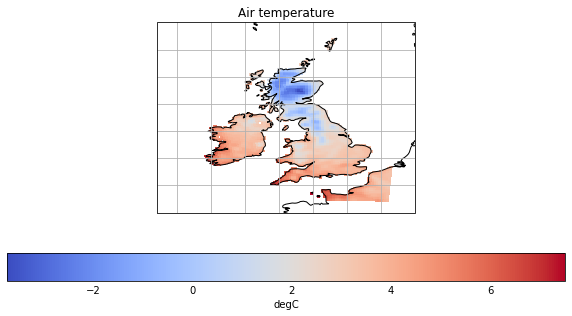

In [16]:
plt.figure(figsize=[10,5])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')  # add coastline
ax.gridlines()  # add gridlines
ax.set_title('test')  # add title
ax.set_extent([-14,5,48,62])  # set domain of plot
qplt.pcolormesh(cube_plot_masked, cmap='coolwarm')

Control more aspects of the plot.

Firstly, extract the projection from the netCDF file

In [17]:
projection = cube_plot_masked.coord('projection_x_coordinate').coord_system.as_cartopy_crs()

Set up the map

Text(0.5, 0, 'Maximum temperature (degrees C)')

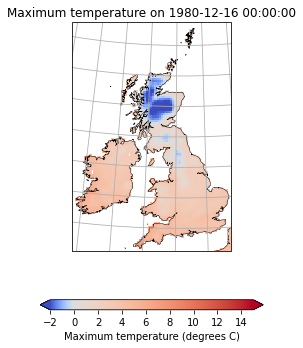

In [18]:
fig = plt.figure(figsize=(4, 6))
ax = plt.subplot(111, projection=projection)

# add gridded colour plot
normplot=TwoSlopeNorm(vcenter=0,vmin=-2,vmax=15)
cm = ax.pcolormesh(cube_plot_masked.coord('projection_x_coordinate').points,
                   cube_plot_masked.coord('projection_y_coordinate').points,
                   cube_plot_masked.data,
                   norm=normplot,cmap='coolwarm')

# prettify plot by adding coastline, modifying titles and colour bar

# add coastline
ax.coastlines(lw=0.5)

# add title
date = str(cube_plot_masked.coord('time').units.num2date(cube_plot_masked.coord('time').points[0]))
plt.title('Maximum temperature on ' + date)

# modify grid and axes
ax.set_xlim([-200000,670000])
ax.set_ylim([0,1250000])
ax.gridlines(lw=0.5)

# modify colour bar
cbar = plt.colorbar(cm, orientation='horizontal', extend='both')
cbar.ax.set_xlabel('Maximum temperature (degrees C)')

## Working with daily files
Load up some new daily tmax data and select period to 2050

Find files to load

In [19]:
file_list = []
for file_path in list(UKCP_FILE_DIRECTORY_TASMAX.glob('tasmax_rcp26_land-gcm_uk_60km_*.nc')):
    file_list.append(str(file_path))   

Load files to 2050 and concatenate into one cube

In [20]:
constraint = iris.Constraint(year=np.arange(1980, 2051), ensemble_member=4)
cube_list = iris.load(file_list, constraint)
tasmax_day = cube_list.concatenate_cube()

Check cube

In [21]:
tasmax_day

Air Temperature (degC),time,projection_y_coordinate,projection_x_coordinate
Shape,25560,23,17
Dimension coordinates,,,
time,x,-,-
projection_y_coordinate,-,x,-
projection_x_coordinate,-,-,x
Auxiliary coordinates,,,
month_number,x,-,-
year,x,-,-
yyyymmdd,x,-,-
latitude,-,x,x


Calculate monthly mean climatology

In [22]:
tasmax_mon = tasmax_day.aggregated_by(['year', 'month_number'], iris.analysis.MEAN)

if not tasmax_mon.coords('season_year'):
    iris.coord_categorisation.add_season_year(tasmax_mon, 'time')   
tasmax_base = tasmax_mon.extract(iris.Constraint(season_year=np.arange(1981, 2001)))
climatology = tasmax_base.aggregated_by('month_number', iris.analysis.MEAN)

Calculate monthly mean anomalies

In [34]:
tasmax_anom = tasmax_mon.copy()
for month_number in np.arange(1, 13):
    constraint = iris.Constraint(month_number=month_number)
    anom = tasmax_mon.extract(constraint) - climatology.extract(constraint)
    indices = np.where(tasmax_mon.coord('month_number').points == month_number)[0]
    tasmax_anom.data[indices, ] = anom.data

Calculate domain mean

In [25]:
tasmax_anom.remove_coord('latitude') 
tasmax_anom.remove_coord('longitude') 
tasmax_anom_xymean = tasmax_anom.collapsed(['projection_y_coordinate','projection_x_coordinate'], 
                                           iris.analysis.MEAN)

Calculate annual mean

In [26]:
tasmax_anom_xymean_annual = tasmax_anom_xymean.aggregated_by(['season_year'], 
                                                        iris.analysis.MEAN)

Let's also compare with absolute values of monthly mean tmax across region

In [27]:
tasmax_mon.remove_coord('latitude') 
tasmax_mon.remove_coord('longitude') 
tasmax_abs_xymean = tasmax_mon.collapsed(['projection_y_coordinate','projection_x_coordinate'], 
                                           iris.analysis.MEAN)

Now plot the results

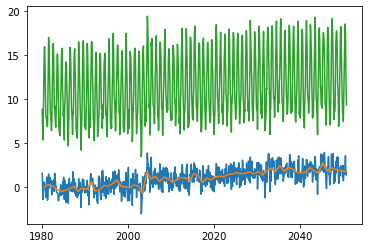

In [30]:
iplt.plot(tasmax_anom_xymean)
iplt.plot(tasmax_anom_xymean_annual)
iplt.plot(tasmax_abs_xymean)

In [33]:
tasmax_anom_xymean[0].data

array(1.5892512, dtype=float32)

In [ ]:
tasmax_mon